In [2]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import uncertainties as u
import uncertainties.unumpy as unp

This section plots the frame potential percentage deviation from the Haar values. First, configure the variables.

In [9]:
ansatze = 'ParallelRandom'

if ansatze == 'ParallelRandom':
    frame_potential = np.load('./results/Parallel_Random/frame_potential.npy')
    qubits = [4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48,50]
    max_l = 14
    min_l = 1
    total_layer_indices = max_l
    # layers to plot for frame potential
    x = np.linspace(min_l, max_l, num=max_l+1-min_l)
    f_lim = [0.001, 100]
    l_lim = 300
elif ansatze == 'LocalRandom':
    frame_potential = np.load('./results/Local_Random/frame_potential.npy')
    qubits = [4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48,50]
    max_l = 7
    min_l = 3
    total_layer_indices = max_l*4
    # local random plots layer to qubit ratio, which grows by 0.25 per step
    x = np.linspace(min_l, max_l, num=(max_l-min_l)*4+1)
    f_lim = [0.01, 1000]
    l_lim = 180
elif ansatze == 'HardwareEfficient':
    frame_potential = np.load('./results/Hardware_Efficient/frame_potential.npy')
    qubits = [2,4,6,8,10,14,18,22,26,30,34,38,42,46,50]
    max_l = 10
    min_l=1
    total_layer_indices = max_l
    x = np.linspace(min_l, max_l, num=max_l+1-min_l)
    f_lim = [0.001, 100]
    l_lim = 120

max_n = max(qubits)
min_n = min(qubits)
colors = cm.cool(np.linspace(0, 1, max_n-min_n+1))

Actual plotting.

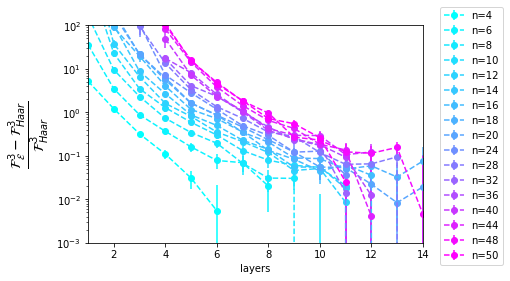

In [10]:
for k in [3]:
    haar = math.factorial(k)

    for n in qubits:
        # select the corresponding portion of the data
        if ansatze == 'LocalRandom':
            # local random plots layer to qubit ratio, which grows by 0.25 per step
            data = np.copy(frame_potential[n-1, min_l*4-1:max_l*4, k-1])
        else:
            data = np.copy(frame_potential[n-1, min_l-1:max_l, k-1])
        # rescaling values (mean and standard error)
        data = data/haar
        # calculate the deviation from the haar value
        data[:, 0] -= 1
        # only plot if there is data available for the trace
        if ~np.all(np.isnan(data)):
            plt.errorbar(x, data[:,0], label='n={}'.format(n), yerr=data[:,1], fmt='o', ls='--', color=colors[n-min_n])
    
    plt.yscale('log')
    plt.ylim(f_lim[0],f_lim[1])
    plt.xlim(min(x),max(x))
    plt.xlabel('layers')
    y_label = '$\\frac{\mathcal{F}_\mathcal{E}^' + str(k) + '-\mathcal{F}_{Haar}^' + str(k) + '}{\mathcal{F}_{Haar}^' + str(k) + '}$'
    plt.ylabel(y_label, fontsize=20)
    plt.legend(loc=(1.05,-0.1))
    plt.show()

The section below estimates the number of layers needed to become $\epsilon$-approximate $k$ designs. First, a linear function and the theoretical layers needed function are defined.

In [11]:
def Linear(x, a, b):
    return a * x + b

def l_needed(n, q, epsilon):
    C = 1/(np.log((q**2+1)/(2*q)))
    return C*(2*n*np.log(q)+np.log(n)+np.log(1/epsilon))

This section fits $\log{\epsilon}$ and calculates $l$.

/tmp/ipykernel_379301/4279836756.py:36: RuntimeWarning: invalid value encountered in log
  n_data[:, 0] = 0.5*np.log(n_data[:,0]) + (k*n)*np.log(2)
/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/uncertainties/core.py:186: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


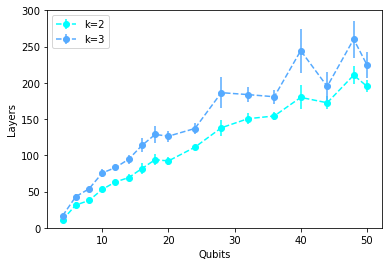

In [12]:
epsilon = 1

ks = [2,3,4,5]
min_k = min(ks)
max_k = max(ks)

# stores all the slopes of the fitted frame potential curves
all_uas = []
# stores all the constant of the fitted frame potential curves
all_ubs = []
# stores all the layers needed to achieve epsilon approximate k designs
all_uls = []
# stores all the numbers of qubits used
all_ns = []

qubit_increment = 2
qubits = range(min_n, max_n+1, qubit_increment)

for k in ks:
    haar = math.factorial(k)
    k_data = np.copy(frame_potential[:, :, k-1])
    params = None
    # stores all the numbers of qubits used for this particular k trace
    k_all_ns = []
    # stores all the fitted parameters
    all_params = []

    '''This block fits log(epsilon) as a linear curve'''
    for n in qubits:
        n_data = k_data[n-1]
        # obtain the deviation in the mean of the frame potential
        n_data[:, 0] = n_data[:, 0] - haar
        # error propagated uncertainty from standard error in the frame potential to the standard error in log(epsilon)
        n_data[:, 1] = 0.5/n_data[:, 0]*n_data[:, 1]
        # calculate epsilon from frame potential deviation
        n_data[:, 0] = 0.5*np.log(n_data[:,0]) + (k*n)*np.log(2)
        try:
            # only fit n that has data
            if ~np.all(np.isnan(n_data)):
                # this block chooses the last layer that is not nan as the last layer, and the first layer that is not nan as the first layer (at least 3)
                first_index = np.nan
                last_index = np.nan
                for index in range(total_layer_indices):
                    mean = n_data[index, 0]
                    std = n_data[index, 1]
                    if (np.isnan(first_index)) and (not np.isnan(mean)):
                        first_index = index
                        first_index = max(first_index, 3)
                    if (np.isnan(mean)) and (not np.isnan(first_index)):
                        last_index = index-1
                        break
                if np.isnan(last_index):
                    last_index = total_layer_indices-1
                if np.isnan(first_index):
                    first_index = last_index - 2
                
                # selecting appropriate data for fitting
                xs =  np.arange(last_index+1-first_index) + first_index + 1
                if ansatze == 'LocalRandom':
                    # converting from index to layer/qubit ratio
                    xs = xs/4
                ys = n_data[first_index:last_index+1, 0]
                sigmas = n_data[first_index:last_index+1, 1]
                # fitting. params is fitted values, and cv is the cross correlation matrix
                params, cv = op.curve_fit(Linear, xs, ys, sigma=sigmas, p0=params)
                # creating correlated fitted variables
                uparams = u.correlated_values(params, cv)
                all_params.append(uparams)
                # indicate that this n value has results
                k_all_ns.append(n)
                
        except:
            print(n,k)
            print(n_data[:,0])
            print(last_index, first_index)
            print(xs, ys)
            raise

    '''This block calculates the layers needed to become epsilon approximate k designs by calculating the intersect of  the fitted curves'''
    all_params = np.array(all_params)
    k_all_ns = np.array(k_all_ns)
    # update what n values have results for this k
    all_ns.append(k_all_ns)
    # correlated epsilon slopes
    ua = all_params[:,0]
    # correlated epsilon bias
    ub = all_params[:,1]
    # calculating layers needed 
    ul = (np.log(epsilon) - ub)/ua
    # updating results to storage lists
    all_uas.append(ua)
    all_ubs.append(ub)
    all_uls.append(ul)

'''This block plots the layer scaling'''
for k in [2,3]:
    i = k-min_k
    plt.errorbar(all_ns[i], unp.nominal_values(all_uls[i]), yerr=unp.std_devs(all_uls[i]), fmt='o', ls='--', label='k='+str(k), color=cm.cool(i/3))

plt.ylim(0, l_lim)
plt.xlabel('Qubits')
plt.ylabel('Layers')
plt.legend()
plt.show()

For the parallel random unitary ansatze, the following analysis is done for small qubit values to establish slopes and $k$ dependence.

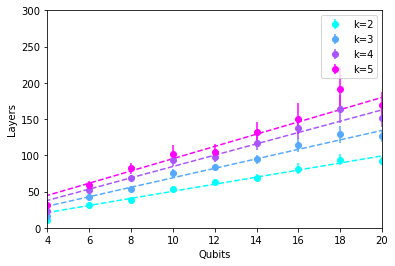

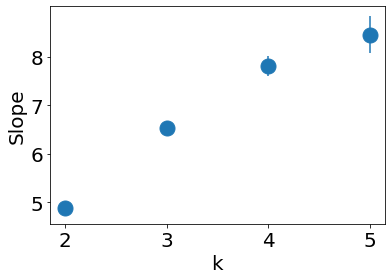

In [13]:
analytic_ns = np.linspace(1, max_n, 100)
slopes = []
slope_err = []
# plotting scaling and fitted curves for few qubits
for k in ks:
    i = k-min_k
    plt.errorbar(all_ns[i], unp.nominal_values(all_uls[i]), yerr=unp.std_devs(all_uls[i]), fmt='o', label='k='+str(min_k+i), color=cm.cool(i/3))
    # fitting only from n=6 to 20
    params, cv = op.curve_fit(Linear, all_ns[i][1:9], unp.nominal_values(all_uls[i][1:9]), sigma=unp.std_devs(all_uls[i][1:9]))
    slopes.append(params[0])
    slope_err.append(cv[0,0])
    plt.plot(analytic_ns, Linear(analytic_ns, params[0], params[1]), '--', color=cm.cool(i/3))

plt.xlim(4,20)
plt.ylim(0, l_lim)
plt.xlabel('Qubits')
plt.ylabel('Layers')
plt.legend()
plt.show()

# plot the fitted slopes
plt.errorbar([2,3,4,5], slopes, yerr=slope_err, fmt='o', markersize=15)
plt.yticks([5,6,7,8], fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.xticks([2,3,4,5], fontsize=20)
plt.xlabel('k', fontsize=20)
plt.show()